# Topic Modelling
### Latent Dirichlet Allocation using sklearn and gensim
***

### sklearn LDA

- The first step is to create an LDA model to label the topics in the document.
- We break the document of size 10000 into 3 topics. The reason we have selected the number of topics as 3 is that more number of clusters do not generate any coherent results and the topics become very sparse. This stops us from inferring any meningful insight from the topics.
- A range of tuning methodologies were tried. We observed best results when using a max_df of 0.8 and min_df of 50.

### gensim LDA 

- Once we have an LDA model, we would want to validate our results and compare them with another model. For this we chose the gensim LDA package.
- The gensim LDA package lets us visualise the data in a more comprehensive manner.
- In the results, we can see that we get 3 very distinct topics with very few shared words.
- This further helps us understand the prominent topics from the tweets and infer a theme.

### Comparing the model with our hypothesis
- We also generate a word cloud of bigrams to compare our initial hypothesis with the generated topics from LDA.

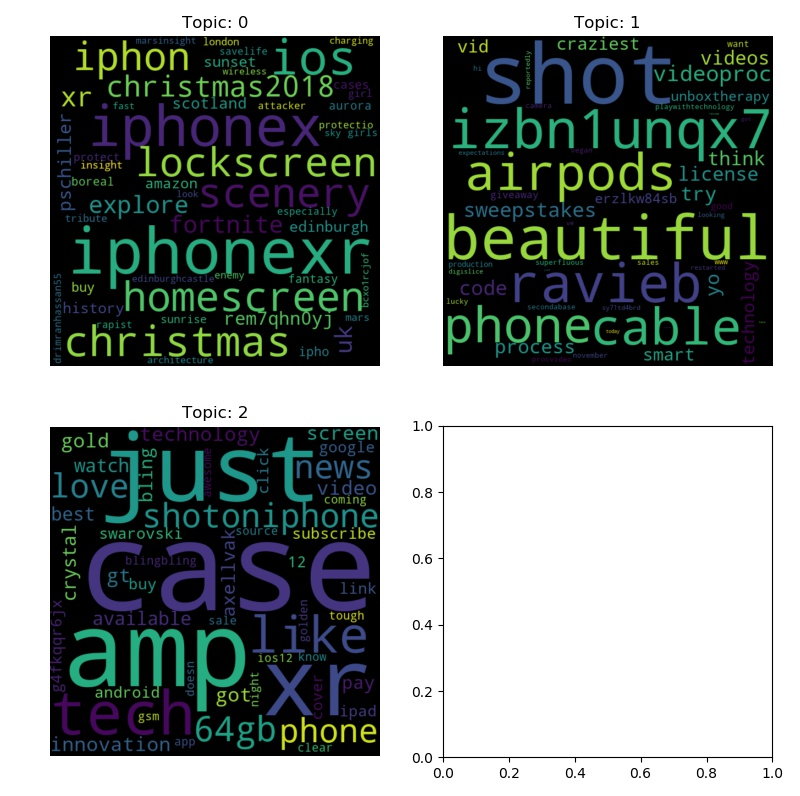

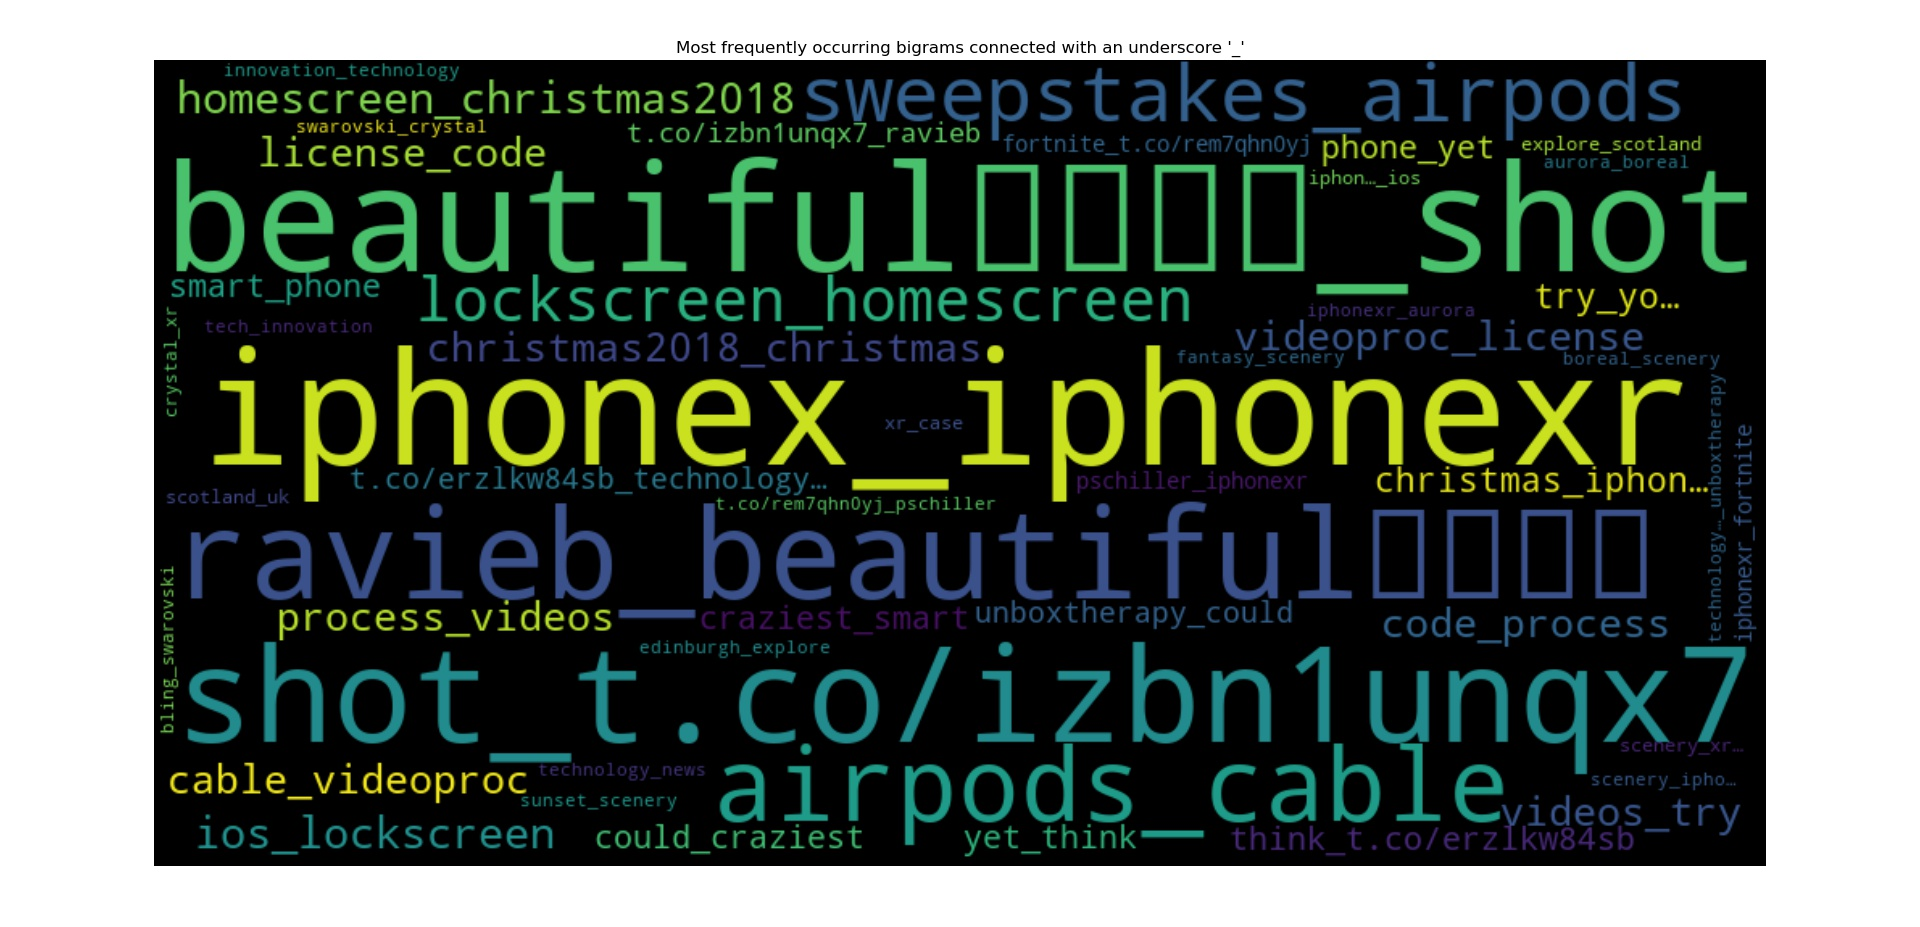

### Testing the model

- To test the accuracy of the model, we labelled 150 documents (50 for each cluster) and derived a classification report from it.

 labels            1.0  2.0  3.0

clusters

        0           6   35   37

        1           4   12    9

        2          14   22   11

This gave us the following classification report:

                    precision    recall  f1-score   support

            1.0       0.30      0.58      0.39        24
            2.0       0.48      0.17      0.26        69
            3.0       0.47      0.65      0.55        57

    avg / total       0.45      0.42      0.39       150

**NOTE: The low accuracy of the model is most likely due to a bias in labelling the test data. Ideally the test data set should be larger and be labelled by experts.**

In [ ]:
# plot charts inline
%matplotlib inline

import os
import math
import gensim
import nltk
import string
import numpy as np
import pandas as pd
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from gensim import corpora
from operator import itemgetter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.metrics import classification_report   
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

# change this to work with a different local file
TEXT_FILE = r"data\iPhoneXS_twitter_eda.csv"
# Number of words in each cloud
NUM_WORDS = 50
# Number of topics
# ! After 3rd cluster, we start seeing some irrelevant data
NUM_TOPICS = 3
# Number of iterations for LDA
REPEAT_COUNT = 20
# a few additional stop words based on context
EXTRA_STOP_WORDS = ["http", "https", "iphone", "apple", "iphoneXS", "iphonexs", "xs", "vs", "iphonexsmax", "wallpapers", "free", "download", "one", "'iphon…",
                    "enter", "chance", "win", "via", "youtube", "comparison", "new", "play", "max", "wallpaper", "ar72014", "’",
                    "follow", "retweet", "post", "comment"]

def cluster_lda(file):
    ''' cluster by utilising LDA topic modelling '''

    data = pd.read_csv(file)
    text = data["text"]
    
    # define custom stop words
    stopwords = ENGLISH_STOP_WORDS.union(EXTRA_STOP_WORDS)

    tf_vectorizer = CountVectorizer(max_df=0.80, min_df=50, stop_words=stopwords)
    tf = tf_vectorizer.fit_transform(text)

    # split dataset into train (90%) and test sets (10%)
    X_train, X_test = train_test_split(tf, test_size=0.1, random_state=0)

    # run LDA
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS, 
                                max_iter=REPEAT_COUNT, verbose=0,
                                evaluate_every=1, n_jobs=1,
                                random_state=0).fit(X_train)

    # get_feature_names() gives all words
    tf_feature_names = tf_vectorizer.get_feature_names()

    return lda, tf_feature_names

def generate_word_cloud(lda, tf_feature_names):
    ''' generate word clouds from LDA cluster '''

    f, axarr = plt.subplots(2, 2, figsize=(8, 8))

    for topic_idx, topic in enumerate(lda.components_):
    # create a dataframe with two columns (word, weight) for each topic
    
        # create a word:count dictionary
        f = {tf_feature_names[i]:topic[i] for i in topic.argsort()[::-1][0:NUM_WORDS]}
        
        # generate wordcloud in subplots
        wordcloud = WordCloud(width=600, height=600, margin=0, background_color="black")
        _ = wordcloud.generate_from_frequencies(frequencies=f)
        
        _ = axarr[math.floor(topic_idx/2), topic_idx%2].imshow(wordcloud, interpolation="bilinear")
        _ = axarr[math.floor(topic_idx/2), topic_idx%2].set_title("Topic: " + str(topic_idx))
        _ = axarr[math.floor(topic_idx/2), topic_idx%2].axis('off')

    plt.tight_layout()
    plt.show()

def plot_bigram_word_cloud(bigram_dict):
    ''' given a dictionary of bigrams with the key as the bigram
        and the value as the frequency, generate a word-cloud '''

    # Set word cloud params
    WC_height = 500
    WC_width = 1000

    wordcloud = WordCloud(max_words=NUM_WORDS, height=WC_height, width=WC_width)
    wordcloud.generate_from_frequencies(bigram_dict)

    plt.title("Most frequently occurring bigrams connected with an underscore '_'")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def visual_gensim_lda(file):
    ''' use gensim LDA to visualise the topics '''

    data = pd.read_csv(file)
    text = data["text"]
    
    # define custom stop words
    stopwords = ENGLISH_STOP_WORDS.union(EXTRA_STOP_WORDS)

    tf_vectorizer = CountVectorizer(max_df=0.90, min_df=50, stop_words=stopwords)
    tf = tf_vectorizer.fit_transform(text)

    # split dataset into train (90%) and test sets (10%)
    X_train, X_test = train_test_split(tf, test_size=0.1, random_state=0)

    # convert the gensim corpus from the sparse tf matrix
    corpus = gensim.matutils.Sparse2Corpus(X_train, documents_columns=False)

    # create the mapping between id and words
    id2word={idx:w for idx, w in enumerate(tf_vectorizer.get_feature_names())}

    # create a gensim dictionary from the corpus
    # a dictionary contains the frequency of each words 
    # the mapping between ids and words
    dictionary = corpora.Dictionary.from_corpus(corpus, id2word=id2word)

    # LDA modelling
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, alpha = 'auto', num_topics = NUM_TOPICS, 
                                        id2word = id2word, iterations = REPEAT_COUNT)

    lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
    pyLDAvis.display(lda_display)

def test_topic_model(file, lda):
    ''' use a test data set to get a classification report '''

    df = pd.read_csv(file)
    df_test = df[0:150]

    tf_vectorizer = CountVectorizer(max_df=0.90, min_df=50, stop_words='english')
    tf_test = tf_vectorizer.fit_transform(df_test["text"])

    topic_assign = lda.fit_transform(tf_test)

    topics = np.copy(topic_assign)
    # topic distribution by highest probability
    topics = np.argmax(topics, axis=1)
    df_test["clusters"] = topics

    # use ctab to find majority vote
    print("\n", pd.crosstab(index=df_test.clusters, columns=df_test.labels))

    # Map cluster id to true labels by "majority vote"
    # XR
    # cluster_dict = {0: 1, 1: 2, 2: 3}
    # XS
    cluster_dict = {0: 3, 1: 2, 2: 1}

    # Map true label to cluster id
    predicted_target = [cluster_dict[i] for i in topics]

    print("\n", classification_report(df_test["labels"], predicted_target))

def prepare_tokens(file, lemmatize=True):
    ''' given a csv file with text
        generates lemmatized tokens '''
    
    data = pd.read_csv(file)
    text = ','.join(data["text"])
    
    tokens = lemmatize_words(text, EXTRA_STOP_WORDS) if lemmatize else get_unigrams(text, EXTRA_STOP_WORDS)

    return tokens

#function used for wordnet tagging
def get_wordnet_pos(pos_tag):
    # if pos tag starts with 'J'
    if pos_tag.startswith('J'):
        # return wordnet tag "ADJ"
        return wordnet.ADJ

    # if pos tag starts with 'V'
    elif pos_tag.startswith('V'):
        # return wordnet tag "VERB"
        return wordnet.VERB

    # if pos tag starts with 'N'
    elif pos_tag.startswith('N'):
        # return wordnet tag "NOUN"
        return wordnet.NOUN

    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        # be default, return wordnet tag "NOUN"
        return wordnet.NOUN

def lemmatize_words(text, extra_stop_words=None):
    stop_words = stopwords.words('english')
    if extra_stop_words is not None:
        stop_words += extra_stop_words

    tokens = nltk.word_tokenize(text)
    tagged_tokens= nltk.pos_tag(tokens)
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # lemmatize all words in the tagged tokens removing stopwords & punctuation
    lemmatized_words=[wordnet_lemmatizer.lemmatize\
            (word, get_wordnet_pos(tag)) \
            # tagged_tokens is a list of tuples (word, tag)
            for (word, tag) in tagged_tokens \
            # remove stop words
            if word not in stop_words and \
            word not in string.punctuation]
    
    return lemmatized_words

def get_unigrams(text, extra_stop_words=None):  
    stop = stopwords.words()
    if extra_stop_words is not None:
        stop += extra_stop_words

    tokens = nltk.word_tokenize(text)
    tokens = [token.strip(string.punctuation) for token in tokens]
    
    #removing stopwords
    tokens = [item for item in tokens if item not in stop]
    
    #remove empty tokens
    tokens=[token.strip() for token in tokens if token.strip() != '']
    
    return tokens

def generate_bigrams(tokens):
    ''' given a list of tokens generates bigrams 
        Cite: https://avidml.wordpress.com/2017/08/03/word-cloud-with-frequently-occurring-bigrams-and-salient-bigrams/ '''


    # setup and score the bigrams using the raw frequency.
    finder = BigramCollocationFinder.from_words(tokens)
    bigram_measures = BigramAssocMeasures()
    scored = finder.score_ngrams(bigram_measures.raw_freq)

    # By default finder.score_ngrams is sorted, however don't rely on this default behavior.
    # Sort highest to lowest based on the score.
    scoredList = sorted(scored, key=itemgetter(1), reverse=True)

    # word_dict is the dictionary we'll use for the word cloud.
    word_dict = {}

    listLen = len(scoredList)

    # Get the bigram and make a contiguous string for the dictionary key. 
    # Set the key to the scored value. 
    for i in range(listLen):
        word_dict['_'.join(scoredList[i][0])] = scoredList[i][1]

    # the bigrams are joined using an underscore
    # as w/o it they don't make sense on the word-cloud
    return word_dict
    
if __name__ == "__main__":

    # 1. generate word clouds post LDA clustering
    lda, tf_features = cluster_lda(TEXT_FILE)
    test_topic_model(TEXT_FILE, lda)
    generate_word_cloud(lda, tf_features)

    # 2. generate word clouds post bigram generation, lemmatization can be turned on/off
    tokens = prepare_tokens(TEXT_FILE, lemmatize=True)
    connected_bigrams = generate_bigrams(tokens)
    plot_bigram_word_cloud(connected_bigrams)

    # 3. visually display the topics of LDA and their clusters
    visual_gensim_lda(TEXT_FILE)


### Gensim LDA result for iPhone XS

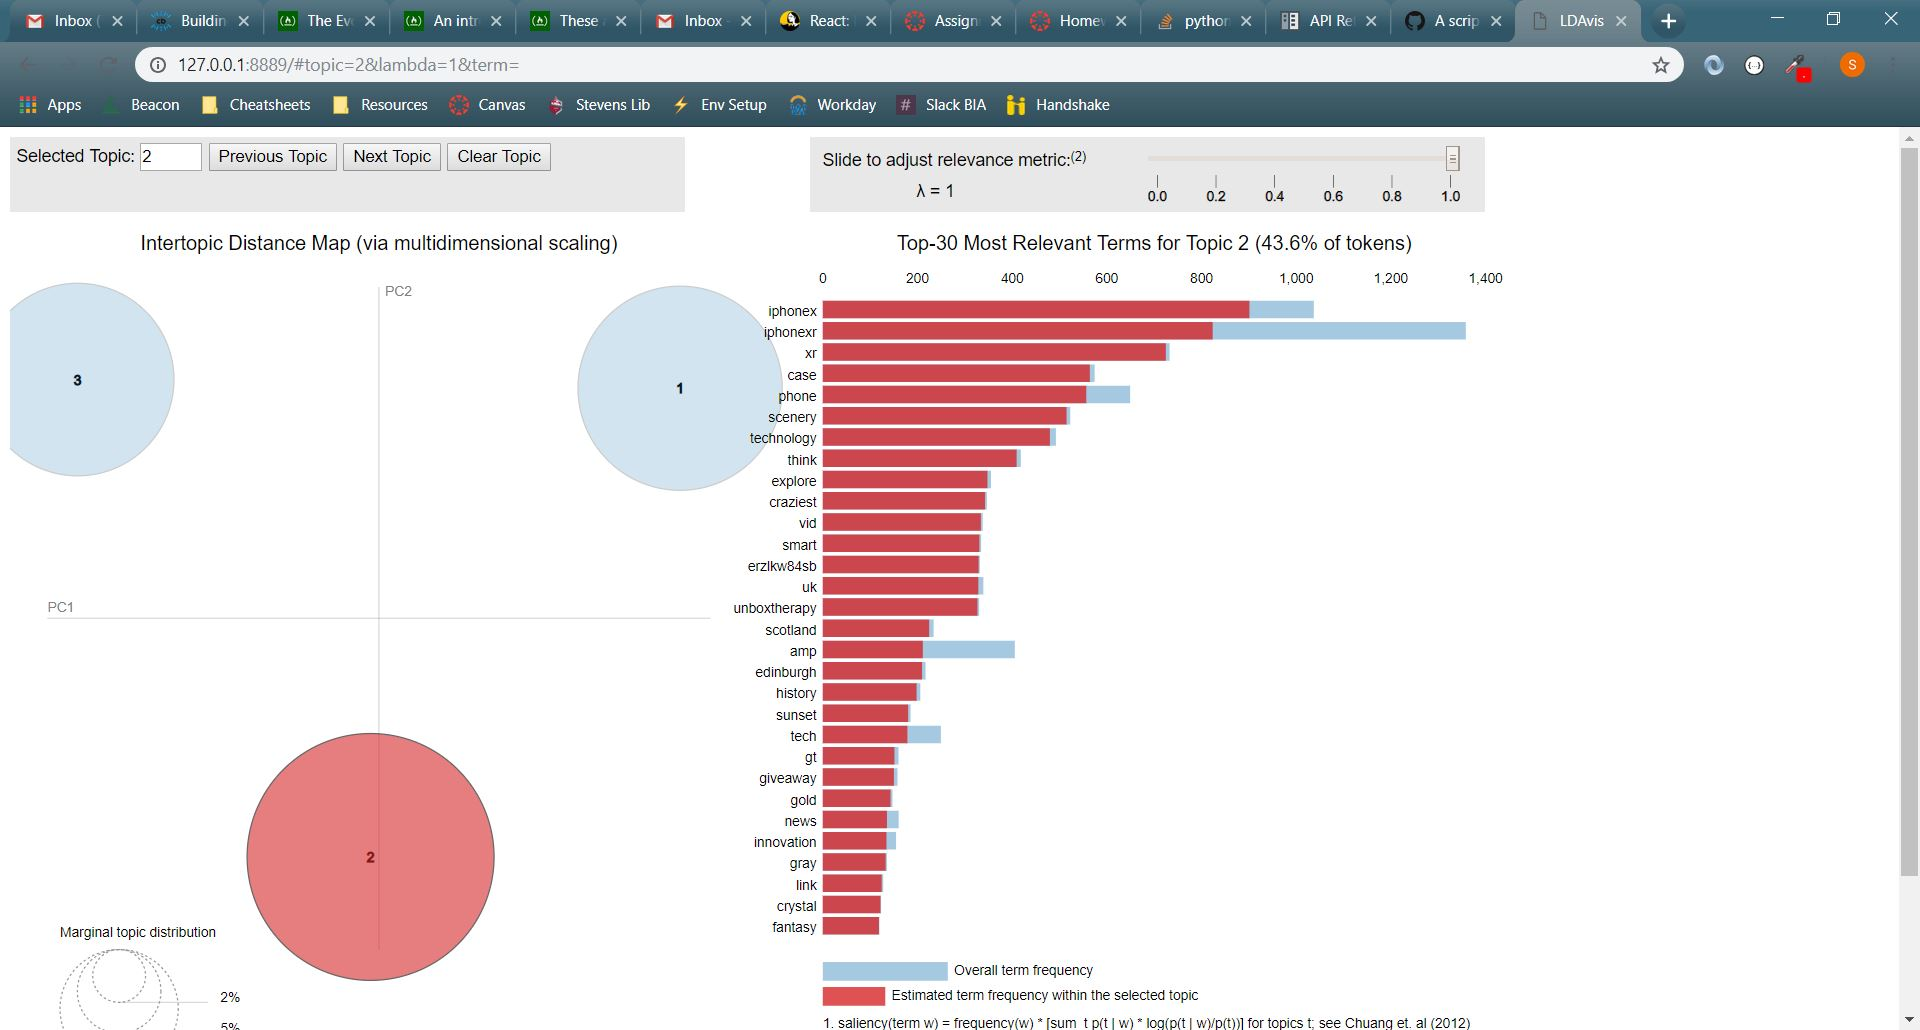